In [1]:
import numpy as np
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import soundfile as sf

from pathlib import Path

In [2]:
import scipy
import pandas as pd
import librosa
import warnings
import os

In [3]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

In [4]:
cfg = get_config()
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/mic_array_test_20240906/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

In [5]:
def run_pipeline_on_file(file, cfg):
    bd_preds = pd.DataFrame()

    if not cfg['output_dir'].is_dir():
        cfg['output_dir'].mkdir(parents=True, exist_ok=True)
    if not cfg['tmp_dir'].is_dir():
        cfg['tmp_dir'].mkdir(parents=True, exist_ok=True)


    if (cfg['run_model']):
        cfg["csv_filename"] = f"batdetect2_pipeline_{file.name.split('.')[0]}"
        filepath = (cfg['output_dir'] / f'{cfg["csv_filename"]}.csv')
        if not(filepath.is_file()):
            print(f"Generating detections for {file.name}")
            segmented_file_paths = batdetect2_pipeline.generate_segmented_paths([file], cfg)
            file_path_mappings = batdetect2_pipeline.initialize_mappings(segmented_file_paths, cfg)
            bd_preds = batdetect2_pipeline.run_models(file_path_mappings)
            if cfg['save']:
                batdetect2_pipeline._save_predictions(bd_preds, cfg['output_dir'], cfg)
            batdetect2_pipeline.delete_segments(segmented_file_paths)
        else:
            bd_preds = pd.read_csv(filepath)

    return bd_preds

In [6]:
def plot_audio_seg_spec(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(audio_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax, mode='magnitude', scale='dB')
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.colorbar()
    plt.show()

def plot_audio_seg_signal(audio_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(audio_features['plot_title'], fontsize=24)
    plt.plot(audio_seg)
    plot_xtype = 'float'
    plt.xlim(0, duration*fs)
    plt.xticks(ticks=np.linspace(0, audio_features['duration']*fs, 11), 
                labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_audio_seg_fft(audio_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(audio_features['plot_title'], fontsize=24)
    abs_sig = np.abs(scipy.fft.rfft(audio_seg))
    abs_sig = abs_sig/ len(abs_sig)
    plt.plot(20*np.log10(abs_sig))
    plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
                labels=np.round(np.linspace(0, (fs/2), 11, dtype=plot_xtype), 2)/1e3, rotation=30)
    plt.yticks(ticks=np.linspace(-120, 0, 6), 
                labels=np.round(np.linspace(-120, 0, 6, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Voltage (dB)")
    plt.xlabel("Frequency (kHz)")
    plt.grid(which='both')
    plt.show()

In [7]:
files_from_loc = sorted(list(Path('/Volumes/Untitled').glob(pattern='*.WAV')))
files_from_loc

[PosixPath('/Volumes/Untitled/20240906_191833.WAV'),
 PosixPath('/Volumes/Untitled/20240906_192619.WAV'),
 PosixPath('/Volumes/Untitled/20240906_200512.WAV')]

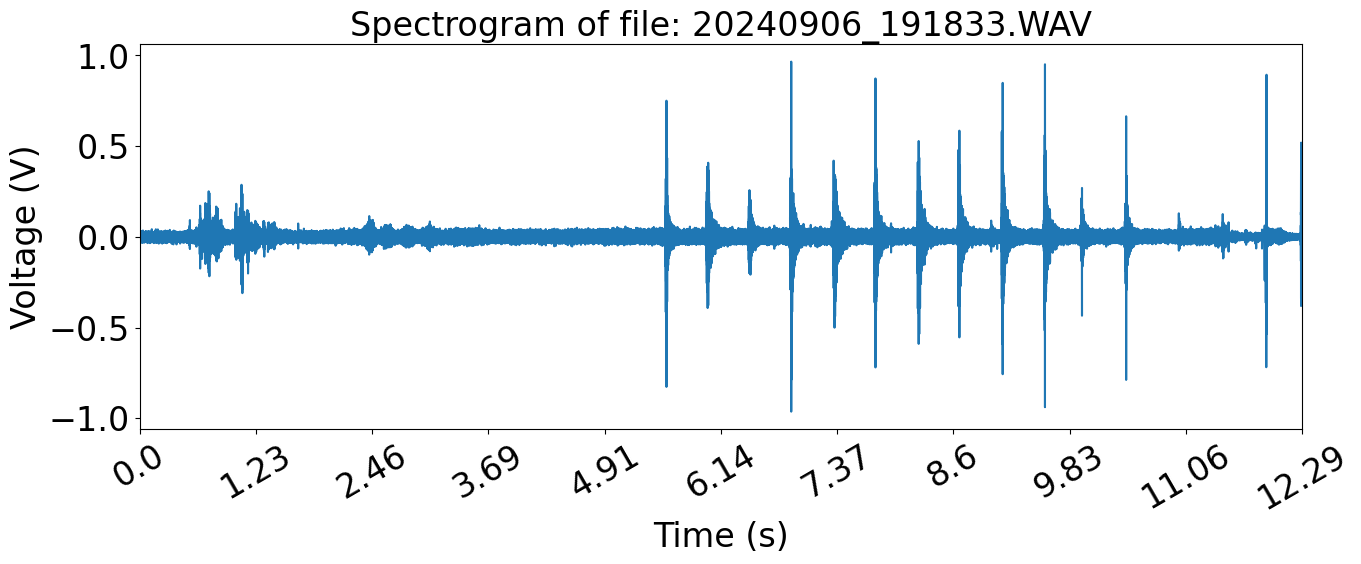

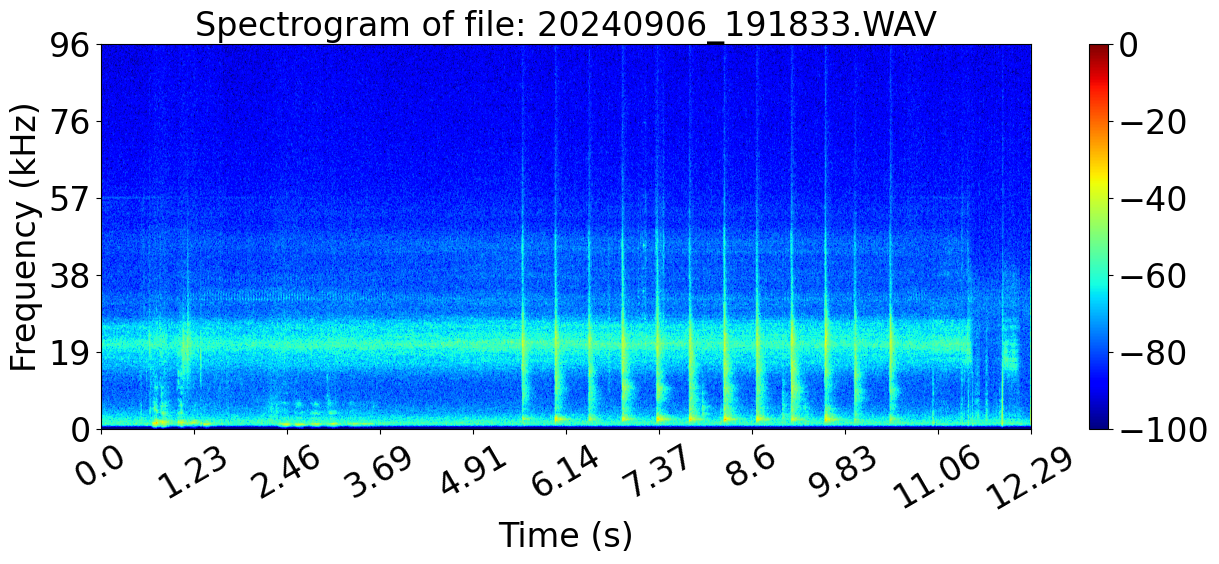

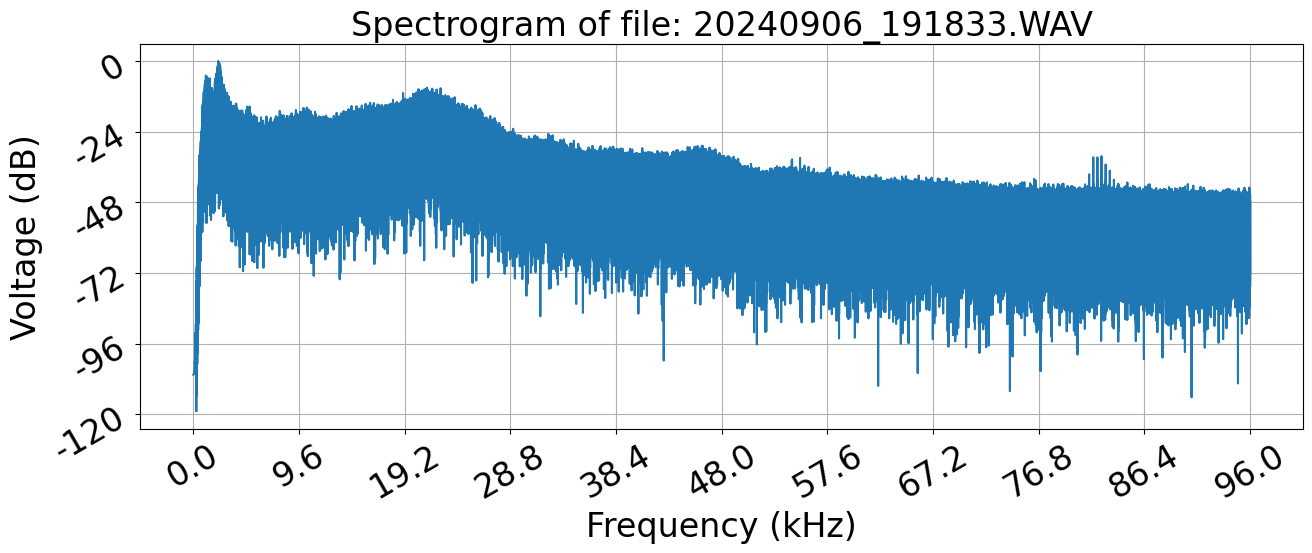

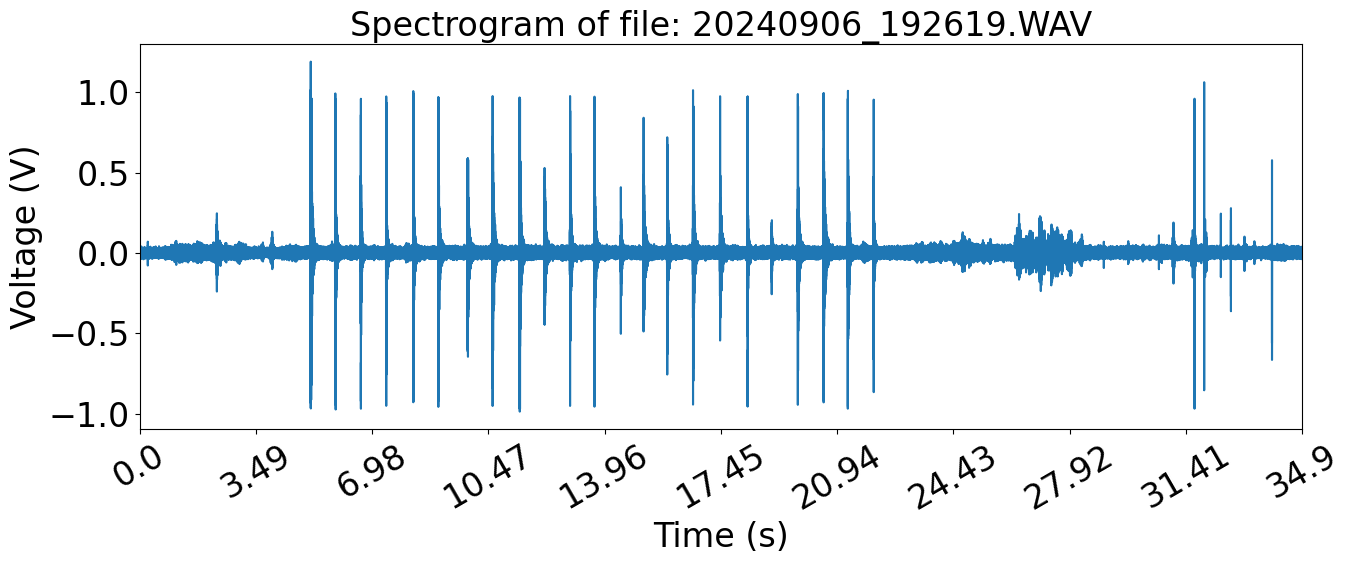

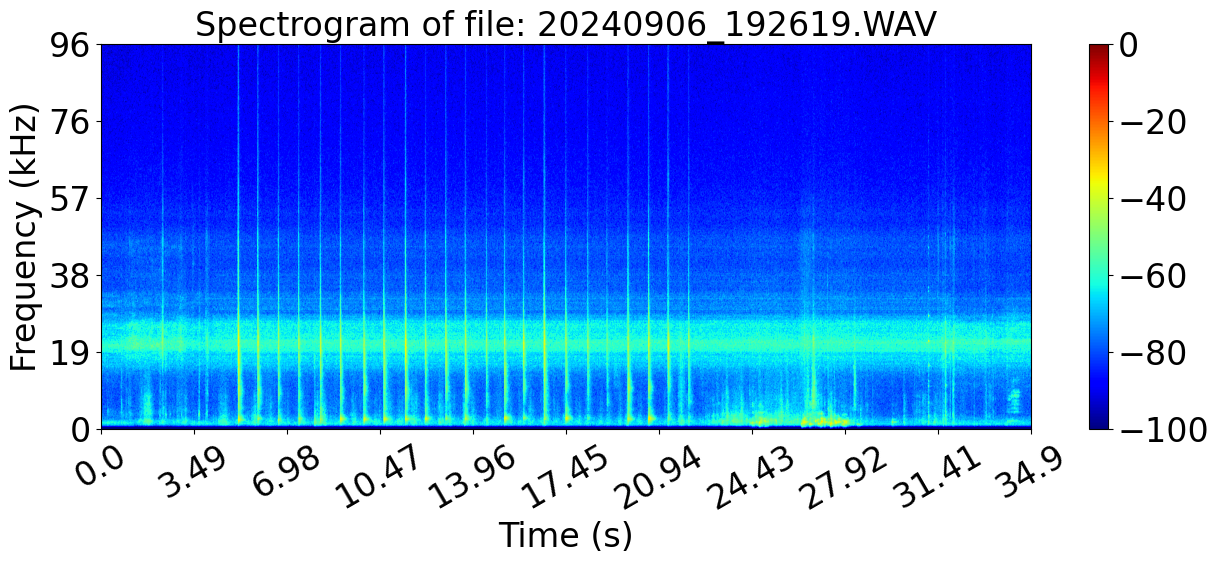

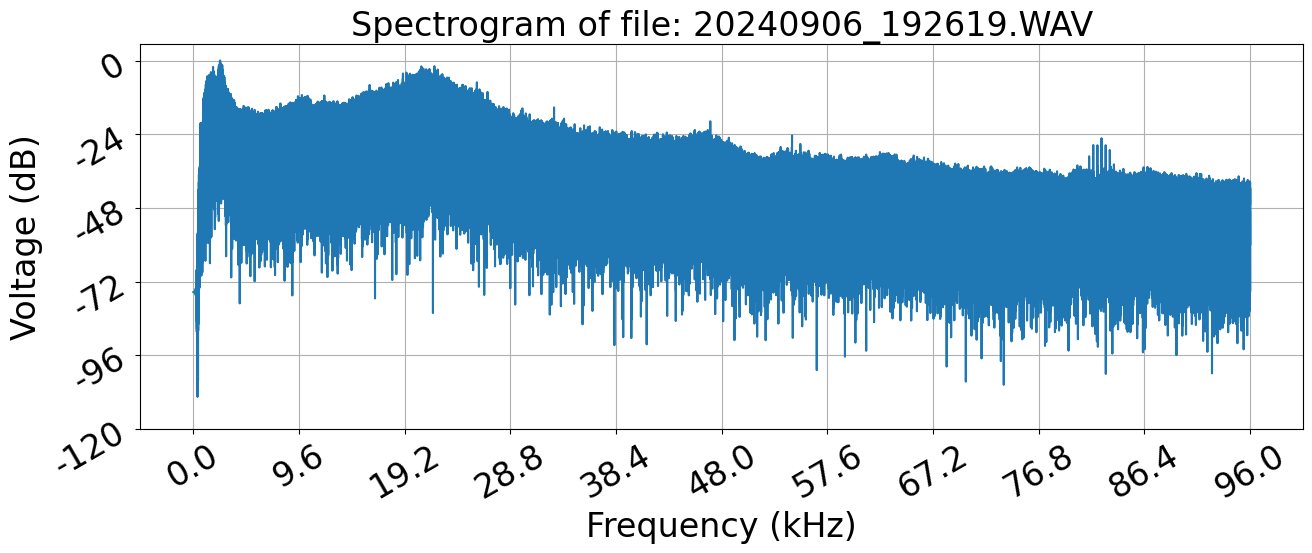

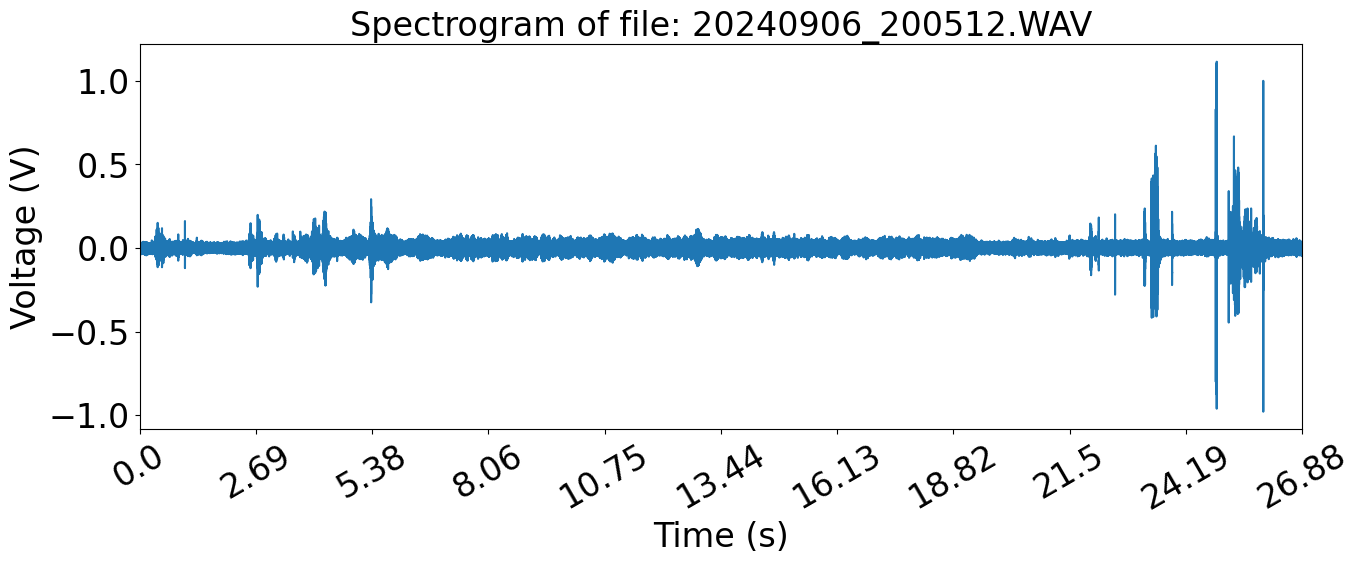

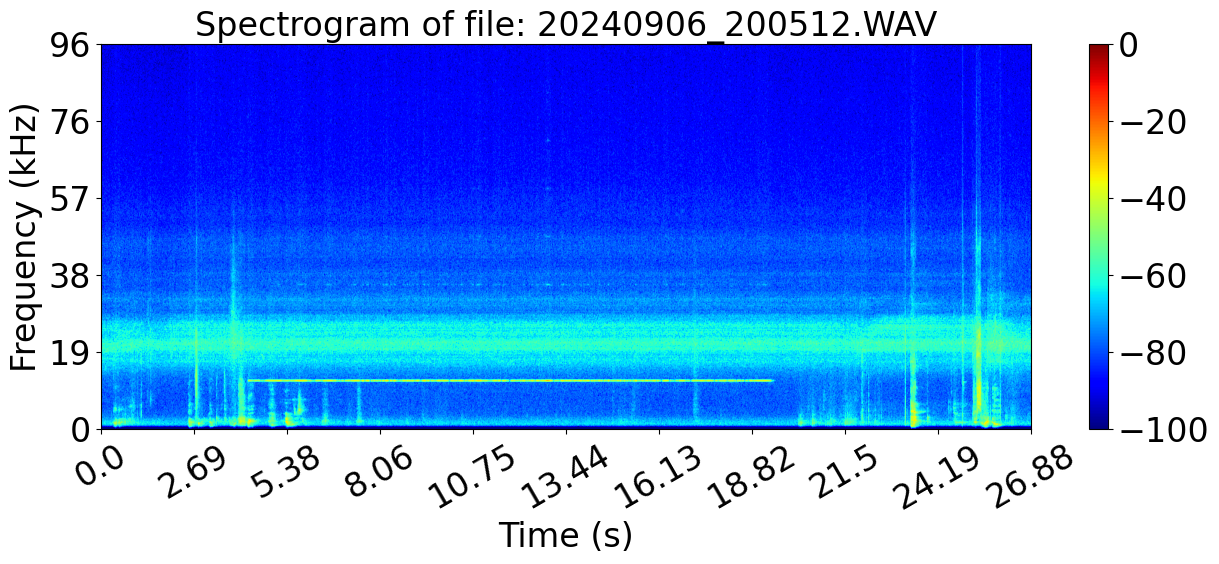

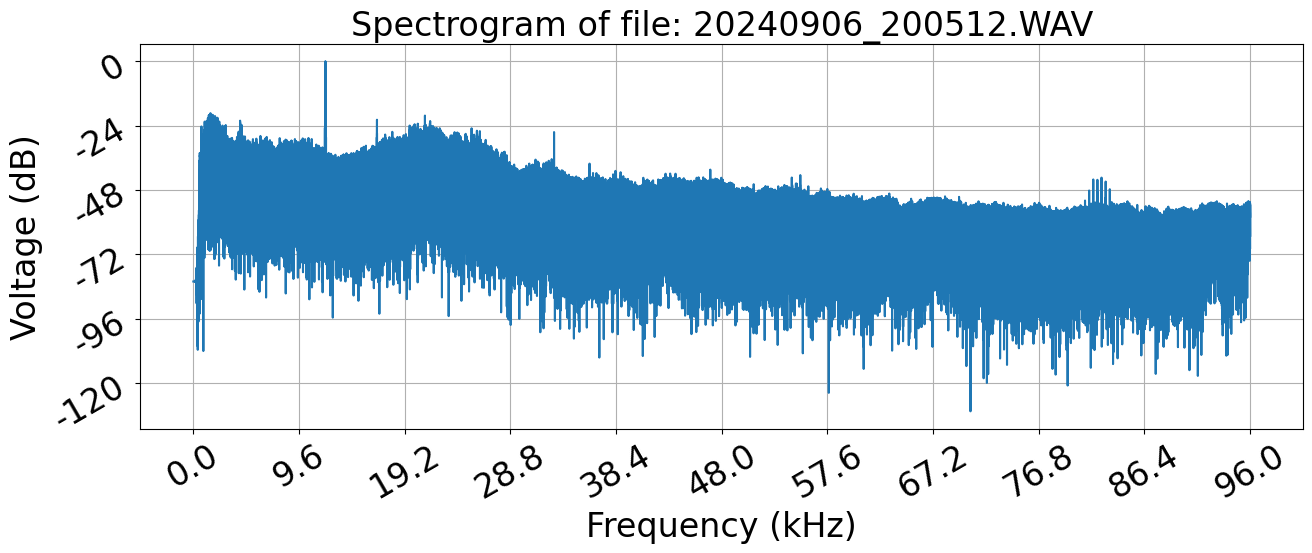

In [8]:
for file in files_from_loc[:]:
    recorded_audio = sf.SoundFile(file)
    fs = recorded_audio.samplerate
    audio_seg = recorded_audio.read()
    vmax = 0
    vmin = -100
    nyq = fs // 2
    low_cutoff = (1000) / nyq
    b, a = scipy.signal.butter(4, low_cutoff, btype='high', analog=False)
    band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    audio_features = dict()
    audio_features['file_path'] = Path(file)
    audio_features['audio_seg'] = band_limited_audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = 0
    audio_features['duration'] = len(band_limited_audio_seg)/fs

    spec_features = dict()
    spec_features['NFFT'] = 1024 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
    spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
    spec_features['vmin'] = vmin
    spec_features['vmax'] = vmax

    audio_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"
    plot_audio_seg_signal(audio_features)
    plot_audio_seg_spec(audio_features, spec_features)
    plot_audio_seg_fft(audio_features)